<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_7_neuromorphic_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/) 
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Neuromorphic Datasets with Tonic + snnTorch
## Tutorial 7
### By Gregor Lenz (https://lenzgregor.com) and Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/examples/tutorial_7_neuromorphic_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

# Introduction
In this tutorial, you will:
* Learn how to load neuromorphic datasets using [Tonic](https://github.com/neuromorphs/tonic)
* Make use of caching to speed up dataloading
* Train a CSNN with the [Neuromorphic-MNIST](https://tonic.readthedocs.io/en/latest/datasets.html#n-mnist) Dataset

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install tonic --quiet 
!pip install snntorch --quiet

## making the synthetic dataset

In [2]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

# Training Parameters
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST has 10 output classes
num_steps = 100

# Torch Variables
dtype = torch.float

from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((34,34)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
from snntorch import utils
from torch.utils.data import DataLoader
from snntorch import spikegen


# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.latency(data_it, num_steps=num_steps, tau=5, threshold=0.8, clip=True, normalize=True, linear=True)

print(spike_data.size())

torch.Size([100, 128, 1, 34, 34])


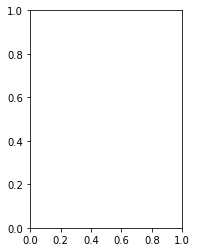

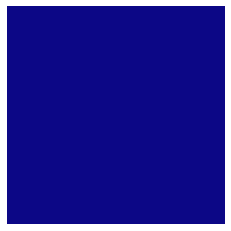

In [4]:
# print(event_tensor[:,0,0].size())
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML


# fig, ax = plt.subplots()
# anim = splt.animator(event_tensor[:,0,1], fig, ax)
event_tensor, target = next(iter(train_loader))

plt.figure(facecolor="w")
plt.subplot(1,2,1)
spike_data_sample = spike_data[:,0,0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())
# plt.imshow(spike_data[:,0,0].mean(axis=0).reshape((34,-1)).cpu(), cmap='binary')

## 2.1 Defining our network
We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

In [5]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device = torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5), #12x32.32
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [7]:
# this time, we won't return membrane as we don't need it 

def forward_pass(net, data):  
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

## 2.2 Training

In the previous tutorial, Cross Entropy Loss was applied to the total spike count to maximize the number of spikes from the correct class.

Another option from the `snn.functional` module is to specify the target number of spikes from correct and incorrect classes. The approach below uses the *Mean Square Error Spike Count Loss*, which aims to elicit spikes from the correct class 80\% of the time, and 20\% of the time from incorrect classes. Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss()
# loss_fn = SF.mse_temporal_loss()

Training neuromorphic data is expensive as it requires sequentially iterating through many time steps (approximately 300 time steps in the N-MNIST dataset). The following simulation will take some time, so we will just stick to training across 50 iterations (which is roughly 1/10th of a full epoch). Feel free to change `num_iters` if you have more time to kill. As we are printing results at each iteration, the results will be quite noisy and will also take some time before we start to see any sort of improvement.

In our own experiments, it took about 20 iterations before we saw any improvement, and after 50 iterations, managed to crack ~60% accuracy. 

> Warning: the following simulation will take a while. Go make yourself a coffee, or ten. 

In [9]:
num_epochs = 5
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
#         data = spikegen.rate(data, num_steps=num_steps)
        data = spikegen.latency(data, num_steps=num_steps, tau=5, threshold=0.8, clip=True, normalize=True, linear=True)


        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets) 
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

#         This will end train÷ing after 50 iterations by default
        if i == num_iters:
          break

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, Iteration 0 
Train Loss: 10.00
Accuracy: 7.81%

Epoch 0, Iteration 1 
Train Loss: 10.00
Accuracy: 7.03%

Epoch 0, Iteration 2 
Train Loss: 10.00
Accuracy: 9.38%

Epoch 0, Iteration 3 
Train Loss: 9.95
Accuracy: 14.84%

Epoch 0, Iteration 4 
Train Loss: 9.82
Accuracy: 14.06%

Epoch 0, Iteration 5 
Train Loss: 9.59
Accuracy: 14.84%

Epoch 0, Iteration 6 
Train Loss: 9.26
Accuracy: 14.84%

Epoch 0, Iteration 7 
Train Loss: 9.00
Accuracy: 13.28%

Epoch 0, Iteration 8 
Train Loss: 9.14
Accuracy: 14.84%

Epoch 0, Iteration 9 
Train Loss: 9.21
Accuracy: 17.97%

Epoch 0, Iteration 10 
Train Loss: 9.03
Accuracy: 13.28%

Epoch 0, Iteration 11 
Train Loss: 8.88
Accuracy: 14.84%

Epoch 0, Iteration 12 
Train Loss: 8.76
Accuracy: 17.19%

Epoch 0, Iteration 13 
Train Loss: 8.90
Accuracy: 22.66%

Epoch 0, Iteration 14 
Train Loss: 8.87
Accuracy: 14.84%

Epoch 0, Iteration 15 
Train Loss: 8.76
Accuracy: 25.78%

Epoch 0, Iteration 16 
Train Loss: 8.73
Accuracy: 21.09%

Epoch 0, Iteration 17 
T


KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

# 3. Results
## 3.1 Plot Test Accuracy

In [ ]:
def batch_accuracy(train_loader, net):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
        
      data = spikegen.rate(data, num_steps=num_steps)
      spk_rec = forward_pass(net, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
test_acc = batch_accuracy(test_loader, net)
print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

## saving the model

In [ ]:
# save_path = 

## 3.2 Spike Counter

Run a forward pass on a batch of data to obtain spike recordings.

In [ ]:
spk_rec = forward_pass(net, data)

Changing `idx` allows you to index into various samples from the simulated minibatch. Use `splt.spike_count` to explore the spiking behaviour of a few different samples. Generating the following animation will take some time.

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



In [ ]:
from IPython.display import HTML

idx = 1

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Conclusion
If you made it this far, then congratulations - you have the patience of a monk. You should now also understand how to load neuromorphic datasets using Tonic and then train a network using snnTorch. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), we will learn more advanced techniques, such as introducing long-term temporal dynamics into our SNNs.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [The Tonic GitHub project can be found here.](https://github.com/neuromorphs/tonic)
* The N-MNIST Dataset was originally published in the following paper: [Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.  “Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades", Frontiers in Neuroscience, vol.9, no.437, Oct. 2015.](https://www.frontiersin.org/articles/10.3389/fnins.2015.00437/full) 
* For further information about how N-MNIST was created, please refer to [Garrick Orchard's website here.](https://www.garrickorchard.com/datasets/n-mnist)